In [1]:
import cv2
import joblib
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

In [2]:
dataset_path = "./"
fixed_size = (300, 300)
n_clusters = 200
bins_color = 8

In [3]:
orb = cv2.ORB_create(nfeatures=500)

In [4]:
image_paths = []
labels = []
descriptor_list = [] 
image_descriptors = [] 

In [5]:
train_labels = os.listdir(dataset_path)
train_labels.sort()

In [6]:
for training_name in train_labels:
    dir = os.path.join(dataset_path, training_name)
    current_label = training_name
    
    if current_label in ['Bacterialblight', 'Brownspot','Healthy','LeafBlast']:
        print(current_label)
        file_list = glob.glob(os.path.join(dir, "*"))
        print(file_list)
        
        for file in file_list:
            image = cv2.imread(file)
            if image is None: continue
            
            image = cv2.resize(image, fixed_size)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            kp, des = orb.detectAndCompute(gray, None)
            
            if des is not None:
                descriptor_list.append(des)
                image_descriptors.append(des)
                labels.append(current_label)
                image_paths.append(file)

Bacterialblight
['./Bacterialblight\\BACTERAILBLIGHT3_001.jpg', './Bacterialblight\\BACTERAILBLIGHT3_002.jpg', './Bacterialblight\\BACTERAILBLIGHT3_003.jpg', './Bacterialblight\\BACTERAILBLIGHT3_004.jpg', './Bacterialblight\\BACTERAILBLIGHT3_005.jpg', './Bacterialblight\\BACTERAILBLIGHT3_006.jpg', './Bacterialblight\\BACTERAILBLIGHT3_007.jpg', './Bacterialblight\\BACTERAILBLIGHT3_008.jpg', './Bacterialblight\\BACTERAILBLIGHT3_009.jpg', './Bacterialblight\\BACTERAILBLIGHT3_010.jpg', './Bacterialblight\\BACTERAILBLIGHT3_011.jpg', './Bacterialblight\\BACTERAILBLIGHT3_012.jpg', './Bacterialblight\\BACTERAILBLIGHT3_013.jpg', './Bacterialblight\\BACTERAILBLIGHT3_014.jpg', './Bacterialblight\\BACTERAILBLIGHT3_015.jpg', './Bacterialblight\\BACTERAILBLIGHT3_016.jpg', './Bacterialblight\\BACTERAILBLIGHT3_017.jpg', './Bacterialblight\\BACTERAILBLIGHT3_018.jpg', './Bacterialblight\\BACTERAILBLIGHT3_019.jpg', './Bacterialblight\\BACTERAILBLIGHT3_020.jpg', './Bacterialblight\\BACTERAILBLIGHT3_021.jp

label
LeafBlast          2516
Brownspot          2439
Bacterialblight    1994
Healthy            1882
Name: count, dtype: int64


<Axes: xlabel='label'>

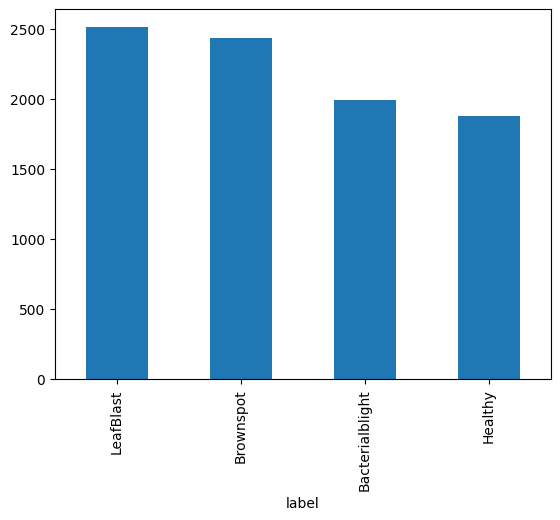

In [7]:
df = pd.DataFrame({"label": labels})

print(df["label"].value_counts())

df["label"].value_counts().plot(kind="bar")

In [8]:
all_descriptors = np.vstack(descriptor_list)

In [9]:
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000, n_init=10)
kmeans.fit(all_descriptors)

,n_clusters,200
,init,'k-means++'
,max_iter,100
,batch_size,1000
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,10


In [10]:
def build_histogram(descriptor, kmeans_model):
    visual_words = kmeans_model.predict(descriptor)
    histogram, _ = np.histogram(visual_words, bins=n_clusters, range=(0, n_clusters))
    
    histogram = histogram.astype('float32')
    
    histogram = cv2.normalize(histogram, None, alpha=1.0, norm_type=cv2.NORM_L2)
    
    return histogram.flatten()

In [11]:
boVW_features = []
for des in image_descriptors:
    hist = build_histogram(des, kmeans)
    boVW_features.append(hist)

In [12]:
X = np.array(boVW_features) 

In [13]:
le = LabelEncoder()
target = le.fit_transform(labels)

In [14]:
scaler = StandardScaler()
rescaled_features = scaler.fit_transform(X)

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(
    rescaled_features,  target, test_size=0.2, random_state=42, stratify= target
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [16]:
num_classes = len(train_labels)
y_train_hot = to_categorical(y_train, num_classes)
y_val_hot   = to_categorical(y_val, num_classes)
y_test_hot  = to_categorical(y_test, num_classes)

In [17]:
model = Sequential()
input_dim = rescaled_features.shape[1]

model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

c:\Users\Allen\Documents\Python Env\environments\computer_fusion\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(
    X_train, y_train_hot,
    epochs=20,
    batch_size=20,
    validation_data=(X_val, y_val_hot),
    verbose=1
)

Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6653 - loss: 0.8339 - val_accuracy: 0.7588 - val_loss: 0.6274
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7886 - loss: 0.5438 - val_accuracy: 0.7950 - val_loss: 0.5274
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8296 - loss: 0.4380 - val_accuracy: 0.8120 - val_loss: 0.4969
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8509 - loss: 0.3827 - val_accuracy: 0.8143 - val_loss: 0.5319
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8657 - loss: 0.3399 - val_accuracy: 0.8256 - val_loss: 0.4825
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8821 - loss: 0.3099 - val_accuracy: 0.8245 - val_loss: 0.4695
Epoch 7/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8913 - loss: 0.2694 - val_accuracy: 0.8324 - val_loss: 0.5006
Epoch 8/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8985 - loss: 0.2562 - val_accuracy: 0.

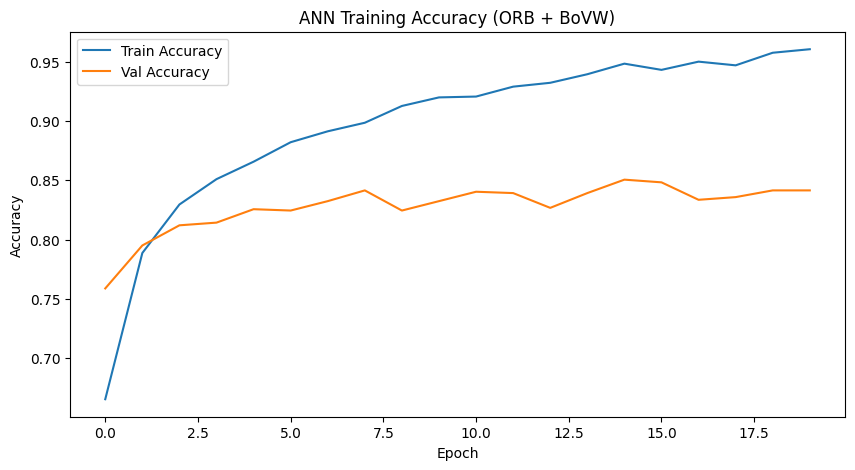

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('ANN Training Accuracy (ORB + BoVW)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.95      0.94      0.95       200
      Brownspot       0.90      0.84      0.87       244
        Healthy       0.74      0.90      0.81       188
      LeafBlast       0.87      0.79      0.83       252

       accuracy                           0.86       884
      macro avg       0.87      0.87      0.86       884
   weighted avg       0.87      0.86      0.86       884



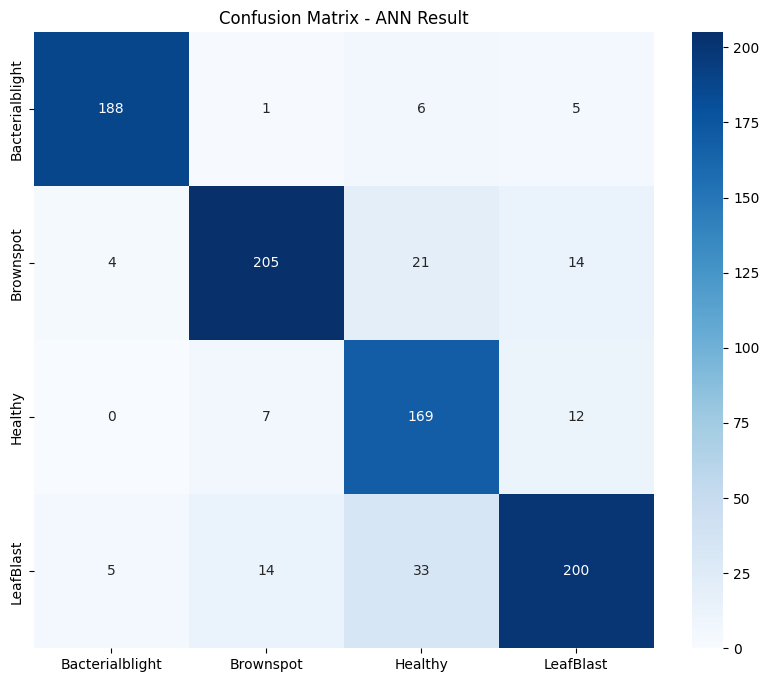

In [22]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - ANN Result')
plt.show()

In [23]:
model.save("model_bovw.keras")

In [24]:
joblib.dump(scaler, "scaler_bovw.pkl")

['scaler_bovw.pkl']

In [25]:
joblib.dump(kmeans, "kmeans_bovw.pkl")

['kmeans_bovw.pkl']